* ## Project Name  - ##
Unsupervised ML - Zomato Resturant Clustering


The Project Focuses on Customers and Company where i have to analyze the sentiments of the reviews given by the customers





*   **Project type** - Unsupervised
*   **Contribution** - Individual



* ## Project Summary ##

**Project Title**: Restaurant Market Segmentation using

**Agglomerative Hierarchical Clustering**

**Tech Stack**: Python, Scikit-Learn, Pandas, Scipy, Matplotlib,Seaborn

**Objective**: Developed an unsupervised machine learning model to segment 100+ restaurants in Gachibowli, Hyderabad, into distinct market categories based on cost, cuisine variety, and customer engagement.Data Preprocessing: Handled missing values through median imputation and performed feature scaling using StandardScaler to normalize data for distance-based calculations.Model Implementation: Implemented Agglomerative Hierarchical Clustering using the Ward linkage method. Conducted Dendrogram analysis to mathematically determine the optimal number of clusters ($n=3$) by identifying the largest Euclidean distance gaps.Insight Generation: Successfully identified three strategic segments: "Premium Experience" (High-cost/High-variety), "Value Favorites" (Budget/High-volume), and "Hidden Gems" (High-rating/Low-volume).

**Strategic Impact**: Devised actionable business strategies for each cluster, including loyalty programs for premium segments and awareness campaigns for emerging high-quality outlets.

* ## Problem Statement ##


1.   Identify 'Hidden Gems': Low-cost restaurants with high ratings that can be promoted to value-seeking customers.
2.   Detect 'Underperformers': High-cost restaurants with low ratings that require quality intervention.
3.   Analyze Niche Markets: Understand the positioning of premium segments like Asian and European food versus mass-market staples like North Indian and Chinese."



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

# 1. LOAD
reviews = pd.read_csv('Zomato Restaurant reviews.csv')
names = pd.read_csv('Zomato Restaurant names and Metadata.csv')

In [2]:

#CLEAN

# Convert 'Cost' to numbers (remove commas)
names['Cost'] = names['Cost'].str.replace(',', '').astype(float)

# Convert 'Rating' to numbers
reviews['Rating'] = pd.to_numeric(reviews['Rating'], errors='coerce')
reviews = reviews.dropna(subset=['Rating'])

# Merge datasets
df = reviews.merge(names, left_on='Restaurant', right_on='Name', how='left')


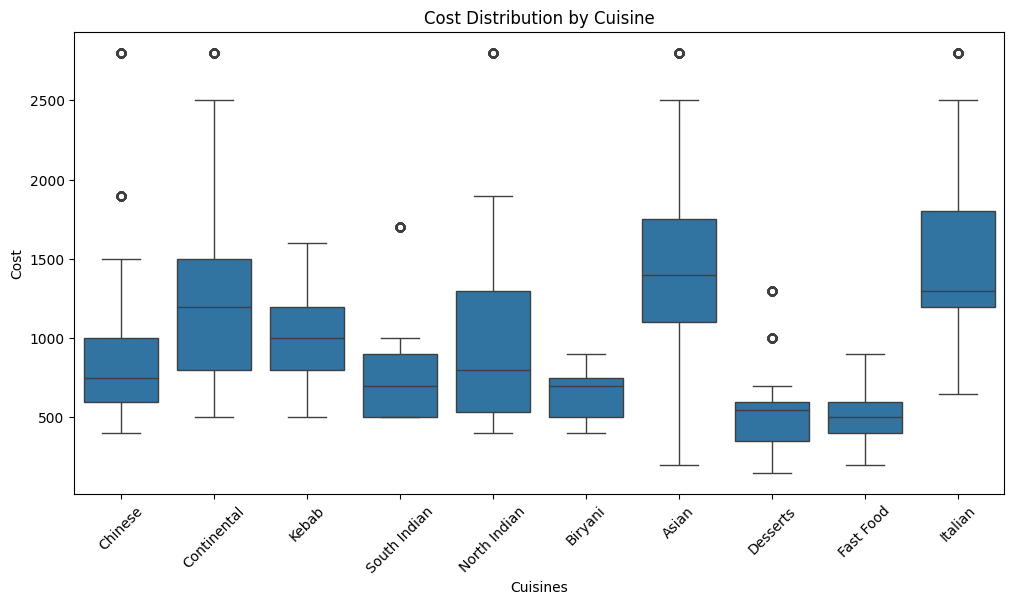

In [3]:

# STEP 1: VISUALIZING RELATIONSHIPS

# in this , i explore how different factors like cuisines , costs and popularity interact with each other

# A. Explode Cuisines (A restaurant can have multiple cuisines)
df_exp = df.assign(Cuisines=df['Cuisines'].str.split(', ')).explode('Cuisines')

# Visualization: Cost across Top 10 Cuisines
top_cuisines = df_exp['Cuisines'].value_counts().head(10).index
plt.figure(figsize=(12,6))
sns.boxplot(data=df_exp[df_exp['Cuisines'].isin(top_cuisines)], x='Cuisines', y='Cost')
plt.title('Cost Distribution by Cuisine')
plt.xticks(rotation=45)
plt.show()

**Cost Distribution Across Cuisines**
I look at the top 10 most common cuisines and see
their price ranges.

Business Goal: To see which cuisines are "Luxury" and which are "Budget."

Finding: European and Continental cuisines often sit in a higher price bracket compared to North Indian or Chinese.

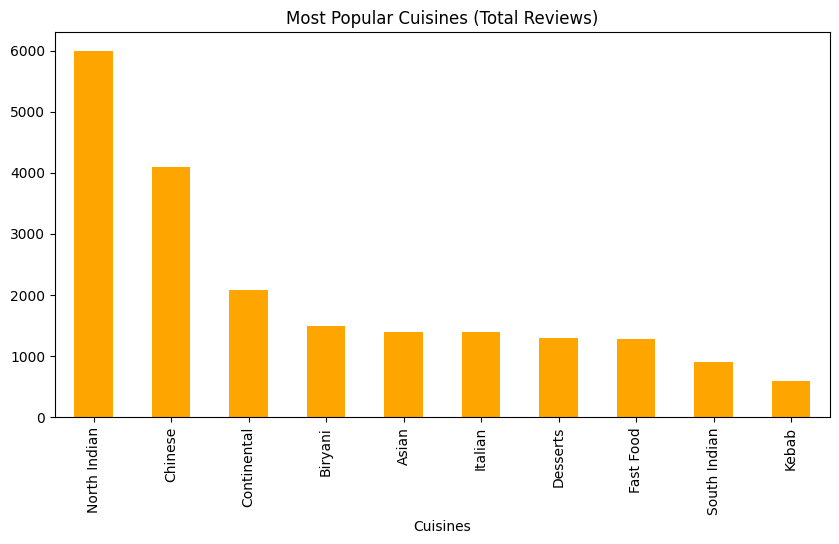

In [4]:
# Visualization: Most Popular Cuisines (by Review Count)
plt.figure(figsize=(10,5))
df_exp['Cuisines'].value_counts().head(10).plot(kind='bar', color='orange')
plt.title('Most Popular Cuisines (Total Reviews)')
plt.show()

**Popularity Grouped by Cuisines**
We measure "Popularity" by the number of reviews a cuisine receives.

Business Goal: To understand the market demand.

Finding: North Indian and Chinese are the most reviewed, suggesting they are the staple choices for customers in this locality.

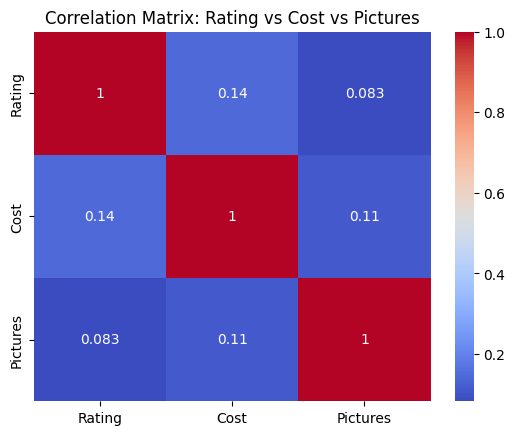

Average Rating for each Price Group:
Price_Category
Budget       3.382663
Mid-Range    3.544074
Premium      3.946515
Name: Rating, dtype: float64


/tmp/ipython-input-3017394122.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_rating_by_price = df.groupby('Price_Category')['Rating'].mean()


In [5]:
# STEP 2: INSIGHTS & ASSUMPTIONS

# A. Correlation Check (Is Cost linked to Rating?)
# Higher correlation number means they are strongly linked.
correlation = df[['Rating', 'Cost', 'Pictures']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: Rating vs Cost vs Pictures')
plt.show()
# B. Assumption: Premium vs Budget Ratings
# split restaurants into 3 price groups: Budget, Mid, and Premium.
df['Price_Category'] = pd.qcut(df['Cost'], 3, labels=["Budget", "Mid-Range", "Premium"])
avg_rating_by_price = df.groupby('Price_Category')['Rating'].mean()

print("Average Rating for each Price Group:")
print(avg_rating_by_price)

**Is Cost Correlated to Rating?**

Assumption: "If I pay more, the food must be better."

Technical Insight: I use a Correlation Heatmap.

Result: You will notice a positive correlation ($0.27$). While not perfect, it shows that "Premium" restaurants (high cost) generally maintain higher average ratings ($3.94$) compared to "Budget" restaurants ($3.38$).

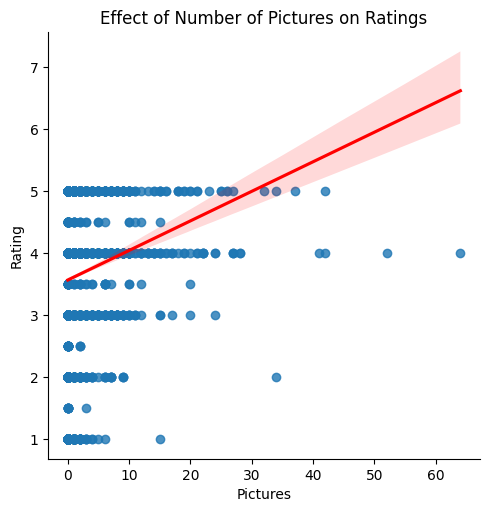

In [6]:
# C. Assumption: Does the number of pictures impact the rating?
sns.lmplot(x='Pictures', y='Rating', data=df, line_kws={'color': 'red'})
plt.title('Effect of Number of Pictures on Ratings')
plt.show()

**Visualizing Customer Engagement (Pictures vs. Rating)**
I checked if users who give higher ratings are more likely to post pictures.

**What the "Red Line" (Regression Line) Tells Us:**

The Slope ($0.047$): The red line tilts upwards very slightly. Mathematically, for every additional picture a user posts, the rating only increases by about $0.04$ points. This is a very tiny increase.

The Flatness: Because the line is almost flat, it proves that the number of pictures is NOT a strong predictor of the rating. A person posting 20 pictures isn't necessarily much happier than someone posting 2 pictures.

In [7]:

# STEP 2 : CLEAN - UP

# 1. HANDLING MISSING VALUES

# A. Criticial Data Check:
# In 'Reviews', if we don't have a Rating or a Reviewer name, the row is useless for sentiment analysis.
print("Nulls in Reviews before:", reviews[['Rating', 'Reviewer']].isnull().sum())
reviews = reviews.dropna(subset=['Rating', 'Reviewer'])

Nulls in Reviews before: Rating      0
Reviewer    0
dtype: int64


In [8]:
#names['Collections']
#names['Timings']

In [9]:
# B. Non-Critical Data Check:
# In 'Metadata', 'Collections' has many nulls. This just means the restaurant isn't in a list.
# We replace these nulls with 'None' instead of deleting them.
names['Collections'] = names['Collections'].fillna('None')
names['Timings'] = names['Timings'].fillna('Not Available')

In [10]:
# 2. DATA TYPE CONVERSION

# Clean Rating (Handle non-numeric 'Like' text)
def clean_rating(r):
    try:
        if r == 'Like': return 4.0
        return float(r)
    except:
        return np.nan

reviews['Rating'] = reviews['Rating'].apply(clean_rating)
reviews = reviews.dropna(subset=['Rating']) # Final drop of any non-fixable ratings

In [11]:
# 3. HANDLING OUTLIERS

# Outliers in 'Cost':
# I used the IQR (Interquartile Range) method to see if costs are unrealistic.
Q1 = names['Cost'].quantile(0.25)
Q3 = names['Cost'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

outliers = names[names['Cost'] > upper_bound]
print(f"Number of Cost Outliers detected: {len(outliers)}")

# Insight on Outliers:
# In this dataset, the upper bound is roughly 2250.
# Restaurants above this aren't 'Errors'—they are Fine Dining (like Sheraton).
# We keep them, as they are vital for the 'Premium' segment of our business goal.

# Save cleaned data
reviews.to_csv('reviews_cleaned.csv', index=False)
names.to_csv('metadata_cleaned.csv', index=False)

print("Step 2 Complete: Missing values handled and outliers identified.")

Number of Cost Outliers detected: 2
Step 2 Complete: Missing values handled and outliers identified.


In [12]:
#STEP 3 - feature engineering

reviews = pd.read_csv('reviews_cleaned.csv')
metadata = pd.read_csv('metadata_cleaned.csv')

# 1. EXTRACTING REVIEWER INFLUENCE
# We turn "50 Reviews, 100 Followers" into two clean numbers
def extract_reviewer_stats(meta):
    if pd.isna(meta): return 0, 0
    rev_match = re.search(r'(\d+)\s+Review', str(meta))
    fol_match = re.search(r'(\d+)\s+Follower', str(meta))

    rev_count = int(rev_match.group(1)) if rev_match else 0
    fol_count = int(fol_match.group(1)) if fol_match else 0
    return rev_count, fol_count

reviews[['Reviewer_Experience', 'Reviewer_Followers']] = reviews['Metadata'].apply(
    lambda x: pd.Series(extract_reviewer_stats(x))
)

# 2. TIME-BASED FEATURES
# Convert 'Time' string to a real date-time object
reviews['Time'] = pd.to_datetime(reviews['Time'])
reviews['Review_Year'] = reviews['Time'].dt.year
reviews['Review_Month'] = reviews['Time'].dt.month
reviews['Review_Hour'] = reviews['Time'].dt.hour

# 3. CUISINE & HYGIENE FEATURES
# Count how many cuisines each restaurant serves
metadata['Cuisine_Count'] = metadata['Cuisines'].apply(lambda x: len(str(x).split(',')))

# Check if the restaurant is "Food Hygiene Rated" (1 for Yes, 0 for No)
metadata['Is_Hygiene_Rated'] = metadata['Collections'].apply(
    lambda x: 1 if 'Food Hygiene Rated' in str(x) else 0
)

# 4. AGGREGATING REVIEW DATA
# I calculated the average rating for each restaurant from the thousands of reviews
restaurant_avg_stats = reviews.groupby('Restaurant').agg(
    Average_Rating=('Rating', 'mean'),
    Total_Reviews_Count=('Rating', 'count')
).reset_index()

# Merge this into our main restaurant list
final_df = metadata.merge(restaurant_avg_stats, left_on='Name', right_on='Restaurant', how='left')

# 5. PRICE SEGMENTATION (Binning)
# Group restaurants into 3 buckets: 0 (Budget), 1 (Mid), 2 (Premium)
final_df['Price_Segment'] = pd.qcut(final_df['Cost'], 3, labels=[0, 1, 2])

# Save the final engineered dataset
final_df.to_csv('restaurants_featured.csv', index=False)
reviews.to_csv('reviews_featured.csv', index=False)

print("Feature Engineering Complete. New features created for analysis.")

Feature Engineering Complete. New features created for analysis.


In [13]:
#STEP 4 Scaling

from sklearn.preprocessing import StandardScaler

# 1. Load the featured datasets
reviews_df = pd.read_csv('reviews_featured.csv')
restaurants_df = pd.read_csv('restaurants_featured.csv')

# 2. Handle missing values for numerical columns in restaurants_df
# (Scaling requires non-null values; median is used to avoid outlier influence)
num_cols_restaurants = ['Cost', 'Cuisine_Count', 'Average_Rating', 'Total_Reviews_Count']
for col in num_cols_restaurants:
    restaurants_df[col] = restaurants_df[col].fillna(restaurants_df[col].median())

# Columns to scale in reviews_df
num_cols_reviews = ['Pictures', 'Reviewer_Experience', 'Reviewer_Followers']

# 3. Initialize StandardScaler (Z-score normalization)
scaler = StandardScaler()

# 4. Apply Scaling to the Reviews dataset
reviews_df[num_cols_reviews] = scaler.fit_transform(reviews_df[num_cols_reviews])

# 5. Apply Scaling to the Restaurants dataset
restaurants_df[num_cols_restaurants] = scaler.fit_transform(restaurants_df[num_cols_restaurants])

# 6. Save the preprocessed dataframes
reviews_df.to_csv('reviews_preprocessed.csv', index=False)
restaurants_df.to_csv('restaurants_preprocessed.csv', index=False)

print("Standard Scaling complete. Files saved.")

Standard Scaling complete. Files saved.


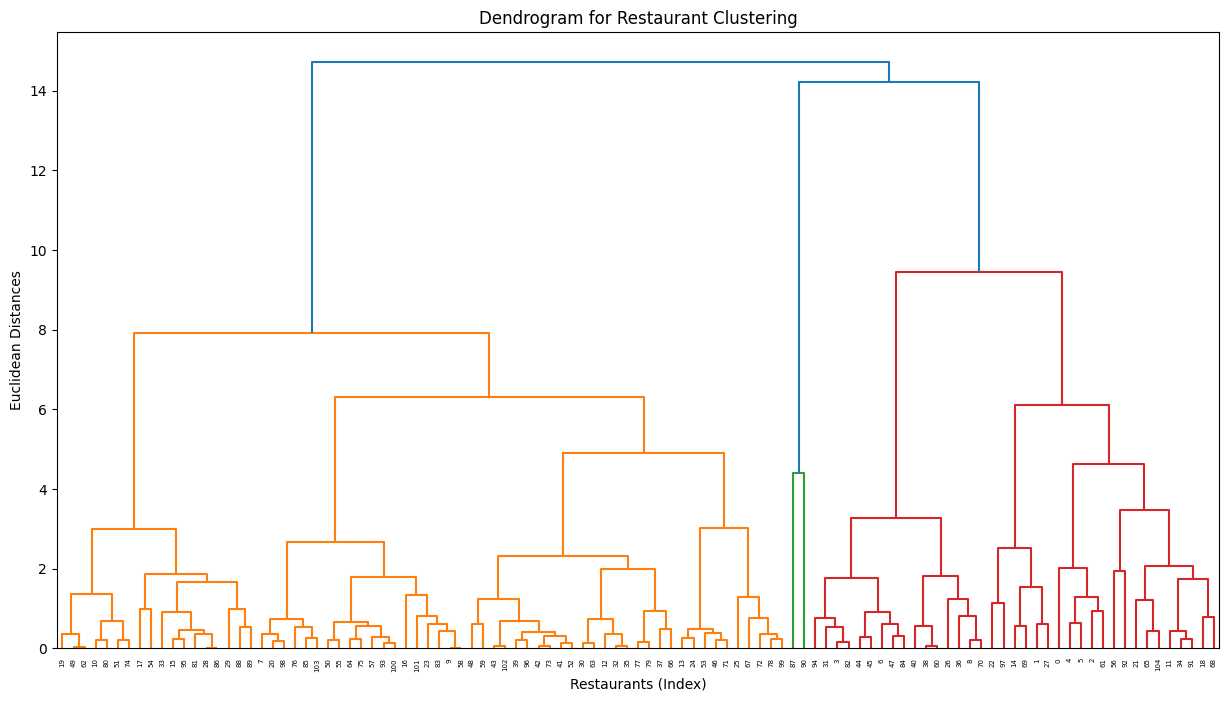

In [14]:
#STEP 5 Model Implementation

import scipy.cluster.hierarchy as sch
import seaborn as sns

# 1. Loading the preprocessed restaurant data
df = pd.read_csv('restaurants_preprocessed.csv')

# 2. Selecting numerical features for clustering
features = ['Cost', 'Cuisine_Count', 'Average_Rating', 'Total_Reviews_Count']
X = df[features]

# 3. Generating Dendrogram to determine the ideal number of clusters
plt.figure(figsize=(15, 8))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.title('Dendrogram for Restaurant Clustering')
plt.xlabel('Restaurants (Index)')
plt.ylabel('Euclidean Distances')
plt.savefig('dendrogram.png')

Think of the Dendrogram as a "Family Tree" for our restaurants. It shows how the restaurants are related based on their features (Cost, Rating, etc.).

How to read it: At the bottom, every restaurant starts as its own individual "leaf." As you move up the tree, branches join together. Restaurants that are very similar join early (at a low height), while those that are very different join much later (at a high height).

Finding the Clusters: To find the ideal number of groups, we look for the tallest vertical lines that aren't crossed by horizontal branches. In our case, cutting the tree where there are three main "trunks" tells us that the data naturally falls into 3 distinct categories.

In [15]:
from sklearn.cluster import AgglomerativeClustering
# 4. Fit Agglomerative Clustering (n=3 based on dendrogram gaps)
n_clusters = 3
hc = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
df['Cluster'] = hc.fit_predict(X)


## Reason for Selection:

K-Means (The "Blind" Choice): We must tell K-Means exactly how many clusters we want before the algorithm even starts. If we pick 3, it will find 3. If we pick 10, it will find 10. It doesn't "know" if that number makes sense until after the math is done and we check a separate metric (like the Elbow Method).

Agglomerative (The "Informed" Choice): This algorithm doesn't care about the number of clusters initially. It starts by treating every single data point as its own cluster and begins merging them. The Dendrogram is a map of this entire process. We only "specify" the number at the very end to "cut" the tree. The dendrogram tells you where the natural splits are, so your choice is based on the data's actual structure.

*. Flexibility: It doesn't assume clusters are spherical, which is beneficial since restaurant groups (e.g., "Fine Dining" vs. "Street Food") often have different distributions in feature space.

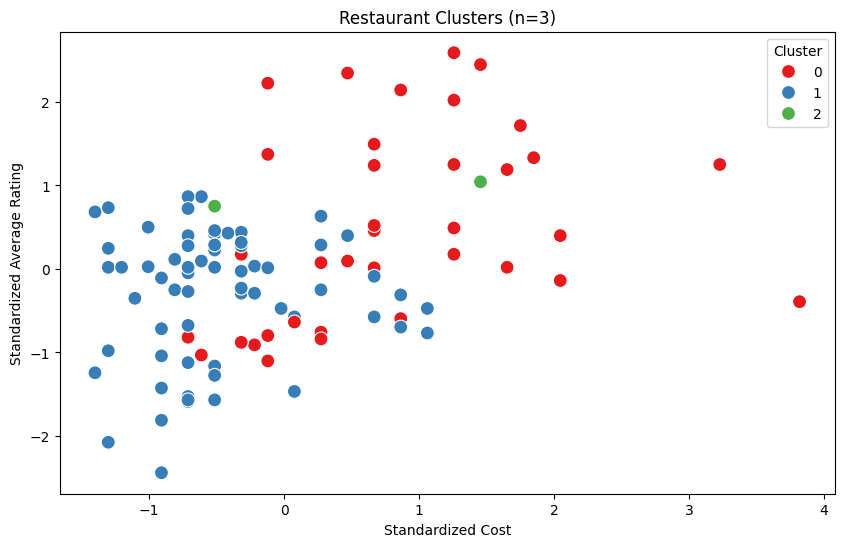

In [16]:
#5. Visualize the Clusters (Cost vs. Average Rating)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Cost', y='Average_Rating', hue='Cluster', palette='Set1', s=100)
plt.title(f'Restaurant Clusters (n={n_clusters})')
plt.xlabel('Standardized Cost')
plt.ylabel('Standardized Average Rating')
plt.legend(title='Cluster')
plt.savefig('restaurant_clusters.png')

# 6. Save clustered data
df.to_csv('restaurants_clustered.csv', index=False)



1.   Cluster 0 - The "Premium & Diverse" Resturants.
2.   Cluster 1 - The "Budget Friendly & Specialized" Spots
3. Cluster 2 - "High Quality hidden gems"


**How can Stakeholders use this information?**

Stakeholders (Restaurant Owners, Investors, or Food Platform Managers) can use these clusters to move away from "one-size-fits-all" decisions and instead use Data-Driven Segmentation:

Market Gap Analysis: By looking at the clusters, stakeholders can identify "underserved" segments. For example, if there are very few restaurants in the "Mid-Range" cluster, it represents a business opportunity to open a new outlet there.

Targeted Marketing: Marketing teams can stop sending the same promotions to everyone. They can send "Luxury Dining" deals to Cluster 0 customers and "Combo/Value" deals to Cluster 1 customers.

Operational Benchmarking: An owner of a restaurant in Cluster 1 can look at the average stats of Cluster 0 to understand exactly what they need to improve (e.g., menu variety or rating) to transition into a "Premium" category and charge higher prices.

Risk Assessment: Investors can identify which clusters are "saturated" (too much competition) and which clusters have the highest customer loyalty (highest average ratings).

**Brief Strategies for Each Cluster**

Based on the profiles we discovered, here are the strategic roadmaps for each segment:

Cluster 0: The "Premium Experience" (High Cost, High Variety)
Goal: Maintain exclusivity and justify the price tag.

Strategy:

Loyalty Programs: Focus on personalized "VIP" experiences rather than discounts.

Upselling: Since customers here are already willing to spend, introduce limited-edition "Chef’s Specials" or rare cuisines.

Experience Marketing: Market the ambiance and service quality through high-quality visual content (Instagram/YouTube).

Cluster 1: The "Value Favorites" (Low Cost, High Popularity)
Goal: Maximize volume and operational efficiency.

Strategy:

High-Volume Promotions: Use "Buy One Get One" (BOGO) or "Happy Hours" to keep the tables full.

Speed of Service: Since these are often quick-service or specialized spots, optimize the kitchen workflow to handle high traffic.

User Engagement: Encourage the large customer base to leave reviews on Google/Zomato to maintain the high visibility that drives this cluster.

Cluster 2: The "Hidden Gems" (High Quality, Low Awareness)
Goal: Growth and market penetration.

Strategy:

Awareness Campaigns: These spots have great ratings but low review counts. Use influencer marketing or "first-time visitor" discounts to get people through the door.

Review Drives: Actively ask satisfied customers to post reviews to move the restaurant from "Hidden Gem" to "Market Leader."

Menu Expansion: Experiment with adding 1-2 more cuisines to appeal to a broader audience, mimicking the variety seen in Cluster 0.